# Milestone 4

# Google Local Data (2021)

**Citation**

**UCTopic: Unsupervised Contrastive Learning for Phrase Representations and Topic Mining**  
Jiacheng Li, Jingbo Shang, Julian McAuley  
*Annual Meeting of the Association for Computational Linguistics (ACL)*, 2022  
[pdf](https://aclanthology.org/2022.acl-long.426.pdf)


**Personalized Showcases: Generating Multi-Modal Explanations for Recommendations**  
An Yan, Zhankui He, Jiacheng Li, Tianyang Zhang, Julian Mcauley  
*The 46th International ACM SIGIR Conference on Research and Development in Information Retrieval (SIGIR)*, 2023  
[pdf](https://arxiv.org/pdf/2207.00422.pdf)

**Data Source**

The Google Local Dataset offers a comprehensive collection from Google Local (Google Maps), featuring 65,000 restaurants and over 1.77 million reviews, along with 4.43 million images posted by approximately 1.01 million users. It contains detailed information such as geographical location, business category,
opening status, price levels, and average ratings for each restaurant. This multi-modal dataset
includes textual reviews, user-generated images, and various metadata attributes, providing a
comprehensive foundation for analyzing consumer preferences and behaviors in the context of
restaurant recommendations.

For our project, we decided to focus on the resturants in Massachusetts, which includes 5,624,944 reviews and 92,520 businesses in metadata.

*Massachusetts 10-cores Review Dataset*
(https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/)

*Masechusetts Metadata*
(https://datarepo.eng.ucsd.edu/mcauley_group/gdrive/googlelocal/)

## Problem Statement Refinement

Based on our preliminary analysis, a potential project question could revolve around understanding how different factors influence consumer ratings and preferences towards restaurants in Massachusetts. More specifically, our project question would be : **How can we leverage natural language processing and sentiment analysis to understand the impact of geographical location, price levels, and review volumes on consumer ratings of restaurants in Massachusetts, and how can this understanding be applied to develop a recommendation system that matches users with restaurants based on their preferences and dining history?**

This question aims to apply the initial analysis of factors influencing consumer ratings with the development of a practical application that improves user experience by personalizing restaurant recommendations. It encapsulates a holistic approach to the data, leveraging insights from the EDA to inform the design and functionality of a recommendation system. This comprehensive question sets the stage for a project that not only uncovers insights through data analysis but also applies these insights in a manner that directly benefits users by enhancing their dining experiences.

## Summary of the Data

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
from copy import deepcopy
import re
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, squareform

import json
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import bigrams, trigrams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
df = pd.read_csv("data/data_ma.csv")
df.count()

/var/folders/jw/fbxyh3ln4nx_m5d05tqlx_dc0000gp/T/ipykernel_44806/244506563.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data_ma.csv")


user_id             1253377
name_x              1253368
time                1253377
rating              1253377
text                 660093
pics                  39142
resp                  91511
gmap_id             1253377
name_y              1253377
address             1252947
description         1072793
latitude            1253377
longitude           1253377
category            1253377
avg_rating          1253377
num_of_reviews      1253377
price               1143581
hours               1223481
MISC                1246033
state                633735
relative_results    1240717
url                 1253377
dtype: int64

In [4]:
print(df.dtypes)
n_users = df['user_id'].nunique()
n_rest = df['gmap_id'].nunique()
print("Number of Users: {}".format(n_users))
print("Number of Restaurants: {}".format(n_rest))

user_id             float64
name_x               object
time                  int64
rating                int64
text                 object
pics                 object
resp                 object
gmap_id              object
name_y               object
address              object
description          object
latitude            float64
longitude           float64
category             object
avg_rating          float64
num_of_reviews        int64
price                object
hours                object
MISC                 object
state                object
relative_results     object
url                  object
dtype: object
Number of Users: 188265
Number of Restaurants: 5893


Our merged dataset comprises 1,253,377 observations and 22 columns, with reviews from 188,265 distinct users for 5,893 different restaurants. For our upcoming NLP tasks, we plan to consider the following features:

* `user_id`: The ID of the user (categorical variable)
* `rating`: The rating given by a user to a restaurant (numerical)
* `text`: The review text (textual data)
* `gmap_id`: The ID of the restaurant (categorical variable)
* `latitude`: The latitude of the restaurant (numerical)
* `longitude`: The longitude of the restaurant (numerical)
* `num_of_reviews`: The number of reviews for a restaurant (numerical)
* `price`: The price index of the restaurant, ranging from $ to $$$$ (categorical variable)

## Data Preprocessing

## Text Preprocessing

### Keep only English reviews

In [5]:
df = pd.read_csv("data/data_ma.csv")

df_filtered = df[-df['text'].isna()].drop_duplicates(
        subset='text', 
        keep='first'
        # The reviews match data/reviews.json
    )[['user_id', 'gmap_id', 'text', 'rating']]

/var/folders/p9/ctjv8l6n4vs3y7f_zyqc9wg80000gn/T/ipykernel_86944/2235338328.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data_ma.csv")


In [ ]:
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

english_mask = df['text'].apply(is_english)

In [ ]:
df_filtered = df_filtered[english_mask]
df_filtered.to_csv("data/english_reviews.csv", index=False)

### Remove emoji

In [7]:
df_filtered = pd.read_csv("data/english_reviews.csv")

emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical symbols
    "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
    "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
    "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
    "\U0001FA00-\U0001FA6F"  # Chess Symbols
    "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
    "\U00002702-\U000027B0"  # Dingbats
    "\U000024C2-\U0001F251" 
    "]+", flags=re.UNICODE)

has_emoji = df_filtered.text.apply(lambda x: bool(emoji_pattern.search(x)))
df_filtered[has_emoji].text.count()

15685

In [8]:
df_filtered['text'] = df_filtered['text'].apply(lambda x: emoji_pattern.sub(r'', x))

### Reduce to extract the k-core for text

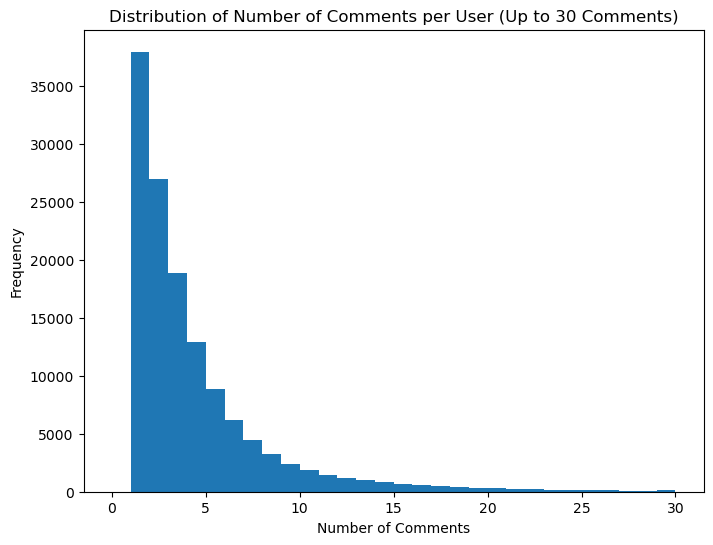

In [9]:
comment_counts = df_filtered['user_id'].value_counts()
threshold = 30

# Plotting the distribution of comment counts, but only up to 50 comments
plt.figure(figsize=(8, 6))
comment_counts[comment_counts <= threshold].hist(bins=threshold, range=(0,threshold))
plt.title(f'Distribution of Number of Comments per User (Up to {threshold} Comments)')
plt.xlabel('Number of Comments')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

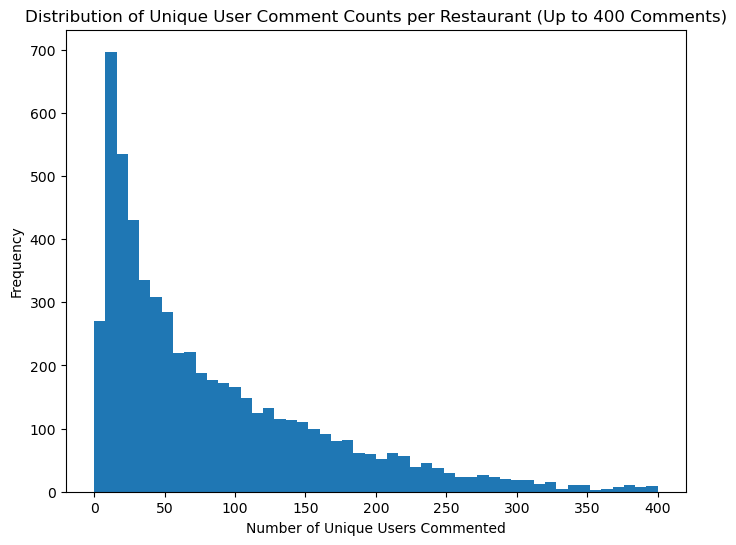

In [10]:
restaurant_user_counts = df_filtered.groupby('gmap_id')['user_id'].nunique()

plt.figure(figsize=(8, 6))
restaurant_user_counts[restaurant_user_counts <= 400].hist(bins=50, range=(0, 400))
plt.title('Distribution of Unique User Comment Counts per Restaurant (Up to 400 Comments)')
plt.xlabel('Number of Unique Users Commented')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [11]:
# Filter to include only those user_ids with more than 10 comments
users_with_more_threshold = comment_counts[comment_counts >= 10].index
df_filtered = df_filtered[df_filtered['user_id'].isin(users_with_more_threshold)]

# Replace '\n' or whitespaces with a white space ' '
df_filtered['text'] = df_filtered['text'].str.replace('\s+', ' ', regex=True)
concatenated_comments = df_filtered.groupby('user_id')['text'].apply(lambda x: '\n'.join(x))

In [12]:
#Prepare train and test set for text vectorization
train_df, test_df = train_test_split(concatenated_comments,
                                     test_size=0.3, random_state=209)

train_df.to_csv('data/user_concat_text_10_train.csv', sep=';', index=True)
test_df.to_csv('data/user_concat_text_10_test.csv', sep=';', index=True)

## Data Cleaning

In [13]:
merged_df = pd.merge(df_filtered, df, on=['user_id', 'gmap_id'])
merged_df.head()

,user_id,gmap_id,text_x,rating_x,name_x,time,rating_y,text_y,pics,resp,...,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,1.089811e+20,0x89e3706a62ba248f:0xdd2878d145d53400,We loved this place and are sad that it is closed,5,Brandon Healy,1498438964371,5,We loved this place and are sad that it is closed,NaN,NaN,...,-71.029044,['Restaurant'],4.8,14,NaN,NaN,"{'Service options': ['Delivery'], 'Highlights'...",NaN,"['0x89e371cb53850b7f:0x7e6646ef9ede69d8', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
1,1.089811e+20,0x89e3706a62ba248f:0xdd2878d145d53400,We loved this place and are sad that it is closed,5,Brandon Healy,1498438964371,5,We loved this place and are sad that it is closed,NaN,NaN,...,-71.029044,['Restaurant'],4.8,14,NaN,NaN,"{'Service options': ['Delivery'], 'Highlights'...",NaN,"['0x89e371cb53850b7f:0x7e6646ef9ede69d8', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
2,1.089811e+20,0x89e3706a62ba248f:0xdd2878d145d53400,We loved this place and are sad that it is closed,5,Brandon Healy,1498438964371,5,We loved this place and are sad that it is closed,NaN,NaN,...,-71.029044,['Restaurant'],4.8,14,NaN,NaN,"{'Service options': ['Delivery'], 'Highlights'...",NaN,"['0x89e371cb53850b7f:0x7e6646ef9ede69d8', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
3,1.089811e+20,0x89e3706a62ba248f:0xdd2878d145d53400,We loved this place and are sad that it is closed,5,Brandon Healy,1498438964371,5,We loved this place and are sad that it is closed,NaN,NaN,...,-71.029044,['Restaurant'],4.8,14,NaN,NaN,"{'Service options': ['Delivery'], 'Highlights'...",NaN,"['0x89e371cb53850b7f:0x7e6646ef9ede69d8', '0x8...",https://www.google.com/maps/place//data=!4m2!3...
4,1.096653e+20,0x89e3706a62ba248f:0xdd2878d145d53400,(Translated by Google) Rancheros eggs! (Origin...,5,Tristan Cunha,1467490763918,5,(Translated by Google) Rancheros eggs!\n\n(Ori...,NaN,NaN,...,-71.029044,['Restaurant'],4.8,14,NaN,NaN,"{'Service options': ['Delivery'], 'Highlights'...",NaN,"['0x89e371cb53850b7f:0x7e6646ef9ede69d8', '0x8...",https://www.google.com/maps/place//data=!4m2!3...


In [14]:
# drop irrelevent columns
df_cleaned = merged_df[['user_id', 'name_y', 'rating_x', 'text_x', 'gmap_id', 'latitude', 'longitude', 'num_of_reviews', 'price', 'avg_rating']]
df_cleaned= df_cleaned.rename(columns={
    'rating_x': 'rating',
    'text_x': 'text'
})
print(df_cleaned.head())
print(df_cleaned.isnull().any())

        user_id            name_y  rating  \
0  1.089811e+20  La Sanghita Cafe       5   
1  1.089811e+20  La Sanghita Cafe       5   
2  1.089811e+20  La Sanghita Cafe       5   
3  1.089811e+20  La Sanghita Cafe       5   
4  1.096653e+20  La Sanghita Cafe       5   

                                                text  \
0  We loved this place and are sad that it is closed   
1  We loved this place and are sad that it is closed   
2  We loved this place and are sad that it is closed   
3  We loved this place and are sad that it is closed   
4  (Translated by Google) Rancheros eggs! (Origin...   

                                 gmap_id   latitude  longitude  \
0  0x89e3706a62ba248f:0xdd2878d145d53400  42.365695 -71.029044   
1  0x89e3706a62ba248f:0xdd2878d145d53400  42.365695 -71.029044   
2  0x89e3706a62ba248f:0xdd2878d145d53400  42.365695 -71.029044   
3  0x89e3706a62ba248f:0xdd2878d145d53400  42.365695 -71.029044   
4  0x89e3706a62ba248f:0xdd2878d145d53400  42.365695 -71.029044

In [15]:
print(f"Percentage of missing review text: {df_cleaned['text'].isna().sum()/len(df_cleaned)*100:.2f}%")
print(f"Percentage of reviews with missing values in 'price' column: {df_cleaned['price'].isna().sum()/len(df_cleaned)*100:.2f}%")

Percentage of missing review text: 0.00%
Percentage of reviews with missing values in 'price' column: 9.11%


In [16]:
# drop missing values
df_cleaned= df_cleaned.dropna()
df_cleaned

,user_id,name_y,rating,text,gmap_id,latitude,longitude,num_of_reviews,price,avg_rating
12,1.089326e+20,Honey Dew Donuts,5,Love the Sale Associates But The Machines I do...,0x89e45e492eda50b1:0x666de2dcb5417546,41.902888,-71.249229,18,$,4.4
13,1.089326e+20,Honey Dew Donuts,5,Love the Sale Associates But The Machines I do...,0x89e45e492eda50b1:0x666de2dcb5417546,41.902888,-71.249229,18,$,4.4
14,1.089326e+20,Honey Dew Donuts,5,Love the Sale Associates But The Machines I do...,0x89e45e492eda50b1:0x666de2dcb5417546,41.902888,-71.249229,18,$,4.4
15,1.089326e+20,Honey Dew Donuts,5,Love the Sale Associates But The Machines I do...,0x89e45e492eda50b1:0x666de2dcb5417546,41.902888,-71.249229,18,$,4.4
16,1.170102e+20,Honey Dew Donuts,5,My favorite coffee place around. Friendly staf...,0x89e45e492eda50b1:0x666de2dcb5417546,41.902888,-71.249229,18,$,4.4
...,...,...,...,...,...,...,...,...,...,...
183235,1.155397e+20,Martha's Vineyard Chowder Company,5,"The food is great, can recommend the oyster sh...",0x89e5290944643609:0x6b5cbf7224fe52bc,41.457841,-70.557289,445,$$,4.4
183236,1.154462e+20,Martha's Vineyard Chowder Company,5,There's a reason why they're the #1 Clam Chowd...,0x89e5290944643609:0x6b5cbf7224fe52bc,41.457841,-70.557289,445,$$,4.4
183237,1.108122e+20,Martha's Vineyard Chowder Company,4,Good food and atmosphere. A bit overpriced but...,0x89e5290944643609:0x6b5cbf7224fe52bc,41.457841,-70.557289,445,$$,4.4
183238,1.120639e+20,Martha's Vineyard Chowder Company,5,Huge food portions and great beer that they wi...,0x89e5290944643609:0x6b5cbf7224fe52bc,41.457841,-70.557289,445,$$,4.4


In [17]:
df_cleaned.price.value_counts()

price
$$      97744
$       58461
$$$      6810
₩₩       1918
$$$$      860
₩         414
₩₩₩       336
Name: count, dtype: int64

In [18]:
# drop rows with price as value '₩₩', '₩',   '₩₩₩₩'   
df_cleaned = df_cleaned[~df_cleaned['price'].isin(['₩₩', '₩', '₩₩₩₩', '₩₩₩'])]
df_cleaned.price.value_counts()

price
$$      97744
$       58461
$$$      6810
$$$$      860
Name: count, dtype: int64

## Comprehensive EDA Review

Our exploratory data analysis of the Massachusetts restaurant reviews has provided valuable insights into consumer behavior and preferences. The reviews reveal a **strong preference towards higher ratings**, suggesting a tendency among patrons to post reviews following positive experiences, or possibly a reluctance to publicly share negative feedback. Our **price category distribution analysis** indicates that a majority of reviews are for **mid-range restaurants**, reflecting a concentration of consumer data in this segment. The relationship between the average ratings and the number of reviews for each restaurant reveals that those restaurants with particularly low ratings (lower than 3) tend to have a low number of reviews. 
The word cloud visualization and frequent word count analysis identified predominant themes focusing on **food quality, service, and overall dining experience**, with high-impact words like "good," "food," "service," and "place" standing out prominently. Additionally, the presence of punctuation, especially exclamation points, may signal strong emotional expressions within the reviews. These findings lay the groundwork for developing a **nuanced restaurant recommendation system** that can parse through natural language to identify and match user preferences with dining experiences tailored to their tastes and expectations.

/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


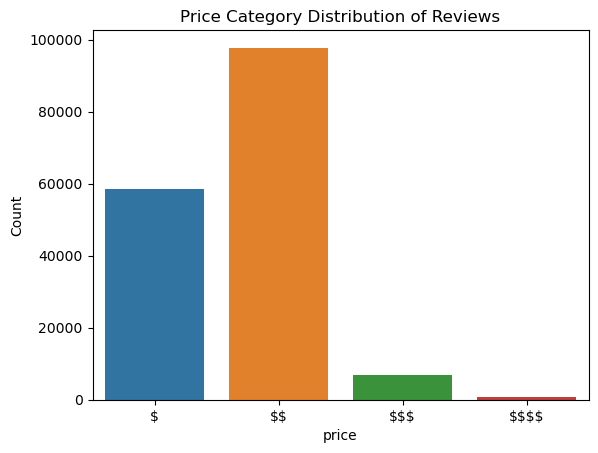

In [19]:
# Plot Review Price Category Distribution
valid_prices = df_cleaned.price
price_lengths = valid_prices.apply(len)

sns.countplot(x=price_lengths)
plt.title('Price Category Distribution of Reviews')
xticklabels = [r'{}'.format('\$' * p) for p in sorted(price_lengths.unique())]
plt.xticks(range(len(xticklabels)), xticklabels) 
plt.ylabel('Count')
plt.show()

/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


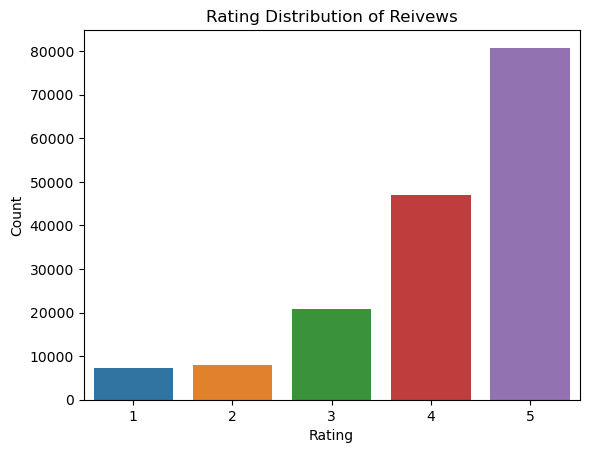

In [20]:
# Plot Review Rating Distribution
sns.countplot(x='rating', data=df_cleaned)
plt.title('Rating Distribution of Reivews')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mashiyu/micromamba/envs/cs109a/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


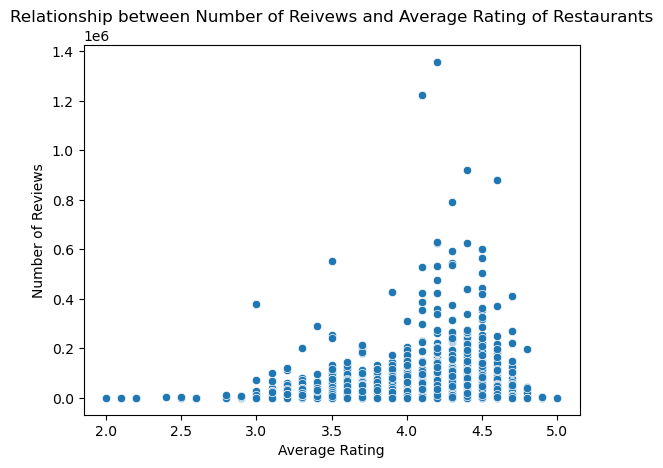

In [21]:
num_reviews_restaurant = df_cleaned.groupby("gmap_id")["num_of_reviews"].sum()
avg_ratings_restaurant = df_cleaned.groupby("gmap_id")["avg_rating"].mean()
sns.scatterplot(x = avg_ratings_restaurant, y = num_reviews_restaurant);
plt.title('Relationship between Number of Reivews and Average Rating of Restaurants')
plt.xlabel('Average Rating')
plt.ylabel('Number of Reviews')
plt.show()

#### Word Cloud for Reivews

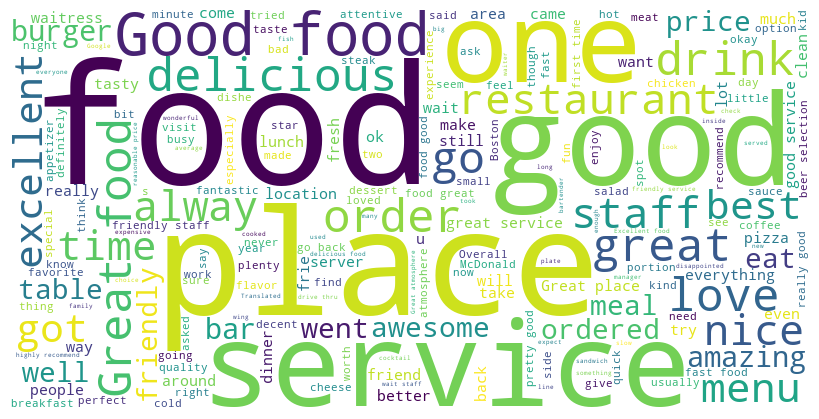

In [23]:
all_reviews = df_cleaned["text"]
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(all_reviews))

# Display the word cloud using matplotlib
plt.figure(figsize = (8, 6), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

## Baseline Model

In recommendation system, content-based recommendation and user-based collaborative filtering are the two main approaches. Content-based recommendation systems are suitable when there's rich metadata available for the resteraurant and when user's unique preferences can be inferred from the characteristics of the resteraurants. They are also advantageous when there's a cold-start problem, as they can recommend resteraurants to new users based on resteraurants' features alone.

On the other hand, user-based collaborative filtering is useful when there's sufficient user interaction data available, such as ratings or visit history. It's effective in capturing user preferences based on their interactions with similar users. User-based collaborative filtering works well in scenarios where users have similar tastes, and it can provide recommendations based on other users' behaviors.

We tried the vanilla version of each approach below:



## Matrix Factorization: item collaborative filtering

In [ ]:
utility = df_cleaned.pivot_table(index = 'gmap_id', columns = 'user_id', values = 'rating', aggfunc='mean')
utility = utility.fillna(0)
utility.head()

user_id,1.000018e+20,1.000020e+20,1.000027e+20,1.000030e+20,1.000057e+20,1.000059e+20,1.000081e+20,1.000084e+20,1.000101e+20,1.000112e+20,...,1.184248e+20,1.184251e+20,1.184277e+20,1.184299e+20,1.184320e+20,1.184382e+20,1.184401e+20,1.184433e+20,1.184449e+20,1.184461e+20
gmap_id,,,,,,,,,,,,,,,,,,,,,
0x405c5a74b3440383:0xa36c9c1781e4be1f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x405d7d631ff16add:0x9bed826678184414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x405da83bbc3429bf:0x7b0a2daaa5c78907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x864819503264d297:0x2b4de82586d8bfef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x89d312eb200a664f:0xb4bbc8c45ca9f926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# similarity = 1- distance
distance_mtx = squareform(pdist(utility, 'cosine'))
similarity_mtx = 1- distance_mtx

In [ ]:
similarity_mtx

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.1839418 , 0.06584147,
        0.1133609 ],
       ...,
       [0.        , 0.        , 0.1839418 , ..., 1.        , 0.14317893,
        0.18014537],
       [0.        , 0.        , 0.06584147, ..., 0.14317893, 1.        ,
        0.13439522],
       [0.        , 0.        , 0.1133609 , ..., 0.18014537, 0.13439522,
        1.        ]])

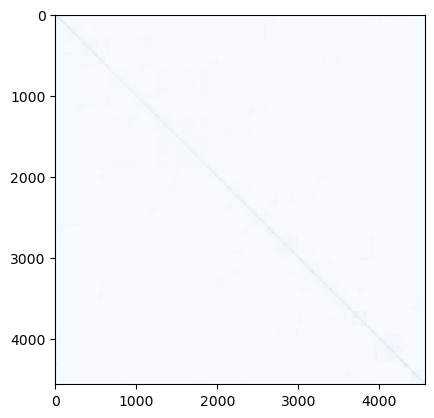

In [ ]:
plt.imshow(similarity_mtx, cmap = 'Blues') #too sparse

The visualization above suggests that user interaction in our dataset is sparse, with users rarely reviewing the same restaurant. As a result, we may not have enough useful information to infer preference similarities between users effectively. Consequently, user-based collaborative recommendation may not be suitable for our dataset.

In [ ]:
#recommend by matrix factorization
#item-item collaborative filtering model

def calculate_user_rating(userid, similarity_mtx, utility):
    user_rating = utility.loc[:,userid]
    pred_rating = deepcopy(user_rating)
    
    default_rating = user_rating[user_rating>0].mean()
    numerate = np.dot(similarity_mtx, user_rating)
    corr_sim = similarity_mtx[:, user_rating >0]
    for i,ix in enumerate(pred_rating):
        temp = 0
        if ix < 1:
            w_r = numerate[i]
            sum_w = corr_sim[i,:].sum()
            if w_r == 0 or sum_w == 0:
                temp = default_rating
            else:
                temp = w_r / sum_w
            pred_rating.iloc[i] = temp
    return pred_rating

In [ ]:
res = calculate_user_rating(userid=df_cleaned.user_id.iloc[0],
                            similarity_mtx=similarity_mtx,
                            utility=utility)
res

gmap_id
0x405c5a74b3440383:0xa36c9c1781e4be1f    5.0
0x405d7d631ff16add:0x9bed826678184414    5.0
0x405da83bbc3429bf:0x7b0a2daaa5c78907    5.0
0x864819503264d297:0x2b4de82586d8bfef    5.0
0x89d312eb200a664f:0xb4bbc8c45ca9f926    5.0
                                        ... 
0x89fca77e3b810389:0x6a6bdb1acb82a3cf    5.0
0x89fca77e3c0f8823:0xa9ca279d40d03c03    5.0
0x89fca77e63bf1171:0xfe805276d1a642b7    5.0
0x89fca77e7dd46023:0x5a13b696296b8553    5.0
0x89fca7819984e3ef:0xe8cc9516b964edaa    5.0
Name: 1.0893259868714716e+20, Length: 4560, dtype: float64

Given the limited number of user-restaurant pairs available, our model predicts this user to rate all other restaurants in the dataset as 5, which is meaningless. Thus, our attempts to employ item-based collaborative filtering for recommendation have proven ineffective. We decided to turn to content-based recommendation models as an alternative approach.

## XGBoost: content-based recommendation

XGBoost can be a suitable choice for a content-based recommendation model for several reasons:

- Scalability: XGBoost is known for its scalability and efficiency, making it suitable for handling our large datasets.

- Feature importance analysis: XGBoost provides a feature importance analysis, which can help identify the most influential features in making recommendations. This information can be valuable for understanding which restaurant attributes or user preferences have the greatest impact on the recommendations, allowing for more interpretable and insightful models.

- High predictive performance: XGBoost is a powerful ensemble learning algorithm that often achieves high predictive performance. In a recommendation system, accurate predictions are crucial for providing relevant and personalized recommendations to users. XGBoost's ability to capture complex patterns in the data can lead to more accurate recommendations.

Overall, XGBoost's versatility, interpretability, scalability, and predictive performance make it our choice for building content-based recommendation models.

To enhance the efficiency of model prediction in XGBoost, we transform the categorical 'price' column into dummy variables.

In [24]:
one_hot = pd.get_dummies(df_cleaned['price'])
df_cleaned = pd.concat([df_cleaned, one_hot], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_cleaned.drop(['rating','text','name_y','price','user_id','gmap_id'], axis=1), 
                                                    df_cleaned[['rating']], 
                                                    test_size=0.3, random_state = 42)
X_train

,latitude,longitude,num_of_reviews,avg_rating,$,$$,$$$,$$$$
82954,42.376975,-71.030264,742,4.3,False,True,False,False
37510,42.461138,-71.164439,177,4.0,False,True,False,False
125655,42.343862,-71.123712,1547,4.4,False,True,False,False
94438,41.971013,-70.714994,136,4.5,False,True,False,False
3430,42.282272,-71.055872,1158,4.2,False,True,False,False
...,...,...,...,...,...,...,...,...
135671,42.503575,-70.922433,669,3.6,True,False,False,False
118525,42.843304,-70.816335,744,4.5,False,False,True,False
148778,42.370493,-71.220651,917,4.7,True,False,False,False
164791,42.342621,-71.120667,548,4.2,False,True,False,False


In [25]:
import xgboost as xgb
model1 = xgb.XGBRegressor(objective='reg:squarederror')
model1.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [27]:
pred1 = model1.predict(X_test)
rmse = np.sqrt(np.mean((pred1 - y_test.to_numpy())**2))
print(f'content-based rmse = {rmse}')

content-based rmse = 1.1666653557946254


In [42]:
feature_importance = pd.DataFrame(model1.feature_importances_, index=X_train.columns, columns=['Importance'])
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)

                Importance
avg_rating        0.781172
$$$               0.034806
$$                0.033904
$                 0.033872
num_of_reviews    0.032100
longitude         0.031654
latitude          0.028401
$$$$              0.024091


### Model Selection and Justification

When deciding between these approaches as our baseline model, we considered the following factors:

- Simplicity: Content-based recommendation systems tend to be simpler to implement because they rely on restaurants' features alone, which can be fit into commonly used models such as XGBoost. Also, the only user-resteraurants interaction data we have is the rating, which turns out to be too sparse to make any valuable conlusion about users' similarities between each others. 

- Interpretability: Content-based recommendation systems are often more interpretable because recommendations based on restaurants' features that can be easily understood and explained. As shown below, our XGBoost can output the feature importance when making the prediction, which help us understand the underlying logic behind the recommendations. 

- Potential Drawbacks: Content-based systems may struggle to recommend diverse or novel restaurants, while Collaborative filtering may struggle with the cold-start problem for new users or restaurants. In our case, we care less about recommend diverse restaurants to users but hopes to maximize the satisifaction rate(rating) of each recommendation we gave. 

Combining the three factors above, we decide to use Content-based as our baseline model.

### Result Interpretation and Analysis

The testing RMSE we achieved in baseline model is about 1.166 which is relative large under the rating scale of 5.

Based on the feature importance extracted from the XGBoost model, it appears that the prediction of customer ratings relies heavily on the average rating of the restaurant. This observation stems from the absence of user-specific features in the dataset that could capture individual preferences towards restaurants. 

Given that the only available user information is derived from their review texts, we recognize the need to extract users' personal preferences from text. To address this limitation, we intend to implement language models such as BERT to vectorize user's reviews. By leveraging these text embeddings, we aim to identify user preferences and enhance the efficacy of our recommendation system.

## Recommendation System Final Model Pipeline


#### **Assumptions:**
1. **User Behavior Consistency**: It is assumed that user preferences do not change drastically over time, meaning historical review data can reliably predict future preferences.
2. **Review Quality**: Reviews are assumed to be truthful and reflective of the users' genuine experiences and sentiments. This underpins the reliance on textual content for deriving user similarities and preferences.
3. **Impact of External Features**: It is assumed that factors like location, price level, and average ratings of restaurants significantly influence user preferences and their final ratings, justifying their inclusion in the feature set.  


##### **Assumptions Specific to Document Embedding:**
1. **Sufficient Textual Data**: For each user, there is enough review text to create meaningful embeddings. This is crucial for methods like Word2Vec and Doc2Vec, which require substantial data to capture semantic meanings effectively.
2. **Contextual Relevance**: The context within which words are used in reviews is assumed to be similar across different users, supporting the use of Word2Vec and other context-based embeddings, which rely on the notion that words used in similar contexts have similar meanings.
3. **Distributional Hypothesis**: For methods like LDA/LSA, it is assumed that topics derived from review texts are meaningful and can capture underlying themes that are indicative of user preferences.


#### **Parameter Choices and Preliminary Tuning:**
- For document embedding techniques, parameters like vector dimensions, context window size, and minimum word count will be tuned.
- For the regression model, regularization methods and hyperparameters will be considered to prevent overfitting.



#### **Pipeline Components:**

**Task 0: Data Preprocessing**
1. **Drop Irrelevant Columns**: Columns such as "resp" and "misc" were removed from our dataset as they are irrelevant to our analysis. The retained columns include 'user_id', 'name_y', 'rating', 'text', 'gmap_id', 'latitude', 'longitude', 'num_of_reviews', 'price', and 'avg_rating', which are pertinent to our recommendation system.

2. **Drop Missing Values and Duplicates**: Since dataset contained a relatively small number of rows with missing values compared to the overall dataset size. Given this, we decided to drop these rows to maintain data integrity. Additionally, duplicate entries were removed to ensure the uniqueness of data points in our analysis.

3. **Drop Uninterpretable Input**: In the price column, we encountered a few entries with unknown symbols ('₩₩', '₩', '₩₩₩₩'). Due to the ambiguity of these symbols and their potential to skew our analysis, we opted to exclude these rows from our dataset.

4. **Filtering Non-English Texts**: We retained only english review texts for analysis. 
5. **Filter users based on number of reviews**: We filted out users with less than 10 reviews from our datatset as there are only very limited information for these users and would be difficult to do recommondation later.  
6. **Concatenation of Reviews**: For each user, we concatenated all their reviews to create a single document per user. This will be used for computing user similarity.
7. **Train/Test Split**: We divided the data into training and testing sets.

**Task 1: User Similarity Computation**
1. **Document Embedding**: Various techniques will be experimented and to vectorize user reviews and compare their performance on the final predictive modeling:
   - **Word2Vec**: Average or TF-IDF weighted vectors of word embeddings.
   - **Bag of Words**: Using TF-IDF or count vectorization.
   - **LDA/LSA**: Generate topic distributions using count or TF-IDF vectorization.
   - **Language Models**: Utilize models such as BERT (or other pre-trained models from platforms like HuggingFace/OpenAI) for embeddings, fine-tuning on our dataset.
   - **Doc2Vec**: Train a Gensim model to obtain document vectors.

   Additional preprocessing steps like lemmatization, stemming, and tokenization (based on whitespace for count/TF-IDF vectorization and specific tokenizer for language models) will be applied as needed for each method.

2. **Similarity Calculation**: Compute cosine similarity scores between users' document vectors.
3. **Predict Ratings**: Use ratings of top \( n \) similar users (e.g., weighted mean of top 5 similar users' ratings) to estimate target user's ratings on a restaurant.


**Task 2: Incorporation of Additional Features**
1. **Feature Engineering**: Extract features like restaurant price level, location, and average restaurant ratings. 
2. **Regression Model**: We integrate the estimated ratings from the previous task, which are based on similar users' ratings, along with additional features, into a regression model to predict final user ratings for a restaurant. We plan to initially use XGBoost (same as our baseline model) for its robustness and efficiency, particularly in handling sparse data and its capability to manage overfitting. Should time allow, we will explore other predictive models or neural networks to optimize our approach further.

3. **Final Recommendations**: We will generate final recommendations by providing users with the top 5 highest-rated restaurants, as determined by the regression model in the previous step. This approach ensures that users receive recommendations that are both personalized and optimized for highest satisfaction.

**Task 3: Model Evaluation**
1. **Error Metrics**: Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) to assess prediction accuracy.
2. **Classification Metrics**: If transforming the problem to a classification (e.g., recommending or not recommending), compute Precision, Recall, and F1-Score based on a defined threshold rating.

#### **Additional Explorations:**

If time permits, we may also incorporate sentiment analysis into our recommendation system pipeline. We plan to analyze the sentiment of reviews on top of a language model and integrate this sentiment data as a feature in the regression model. This addition aims to enhance the recommendation process by considering the positive, negative, or neutral tones of the reviews.
